# ADS504 - Final Project
# Real vs Fake Job Classification
# Team 2 - Stephen Kuc, Hunter Blum, Mendelina Lopez


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler

from imblearn.under_sampling import RandomUnderSampler

In [4]:
job = pd.read_csv('fake_job_postings.csv')
job.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


How to attack this problem?

For text features, should we see how much each may have an affect on the real or fake job post? And then do some feature selection from there, and THEN, at that point, combine them?



## EDA 
### Structure of data

In [5]:
job.shape

(17880, 18)

17,880 observations and 18 total features.
Let's check nulls

In [6]:
job.isnull().sum()


job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
job.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Many of the first features are text data, a few are binary (1,0) features,  some categorical, and :salary_range may need other transformation. 

In [8]:
job.nunique()


job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

employment_type, required experience, required education, function can be categorical. Industry - perhaps attacked like text data or encoded




In [9]:
# checking number of nulls in each row

NA_row = []
for i in range(len(job.index)):
  na_temp = job.iloc[i].isnull().sum()
  NA_row.append({'row': i+1, 'NAs': na_temp})

NA_row = pd.DataFrame(NA_row)
NA_row = NA_row.sort_values('NAs', ascending=False)
NA_row

,row,NAs
11077,11078,11
144,145,11
16627,16628,11
17756,17757,11
2315,2316,11
...,...,...
15825,15826,0
11435,11436,0
11441,11442,0
15789,15790,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


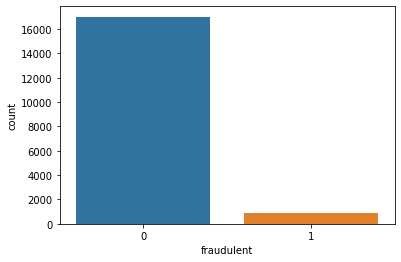

In [10]:
# creating labels / checking class distribution

labels = job['fraudulent']

sns.countplot(labels)

Do nulls have an affect on fraudulent?

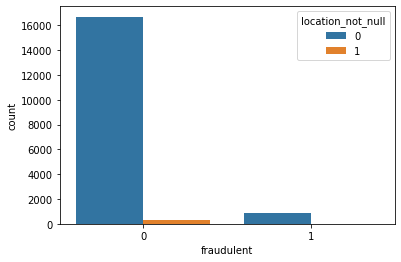

In [ ]:
job['location_not_null'] = np.where(job['location'].isnull(), 1, 0)
sns.countplot(x="fraudulent", hue="location_not_null", data=job)

Maybe worth it to look at more features?

There is some class imbalance we must deal with later on. Let's get a closer look at text features

## Undersample to balance classes

In [16]:
X = job.drop(columns = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent'])
y = np.array(job['fraudulent'])

undersample = RandomUnderSampler(random_state = 42)
Job_under, y_under = undersample.fit_resample(X,y)
Job_under['fraudulent'] = y_under

In [46]:
# let's look at each text feature
# text features are:
# 'title', 'location', 'company_profile', 'description', 'requirements', 'benefits' and (perhaps) 'industry'
# going to fill text nulls with " " 

text = Job_under[['title','location', 'department', 'company_profile', 'description', 'requirements', 'benefits']]
text.fillna(" ", inplace = True)
text.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,title,location,department,company_profile,description,requirements,benefits
0,SEM Coordinator,"GR, I, Athens",,#URL_c379aa631173ed5b7c345ab3f500a9a053e509138...,The right candidate will be responsible for co...,- Previous experience of minimum 3 years...,- Attractive Remuneration Package.- ...
1,Senior Data Scientist,"GB, LND, London",Engineering,"As a growing and successful startup, Conversoc...",Conversocial builds software that helps compan...,Good working knowledge of Python or similar la...,Salary of £40-55k plus stock options£2k annual...
2,Junior Web Marketing Specialist,"GR, I, Ilion",Web Marketing και Social,Η Atnet Communications A.E. είναι μια αμιγώς ε...,Η Atnet Communications αναζητά Junior Web Mark...,Απαιτούμενα προσόντα:Hands-on εμπειρία στην δι...,H θέση αφορά μόνιμη απασχόληση στην περιοχή το...
3,New Product Development Project Leader - Full ...,"US, GA, Atlanta",,We Provide Full Time Permanent Positions for m...,Coordination and project management of New Pro...,"Location - Atlanta, GA, USAJob Type – Permanen...",
4,Data Intern - Retail & Apparel Analysis,"GB, LND, London",Fashion:Internships,"We build software for fashion retailers, to he...",About EDITDEDITD’s software is the market lead...,,


Vectorizing each text document

In [18]:
# vectorizing title

vectorizer = TfidfVectorizer()
spmat_title = vectorizer.fit_transform(text['title'])
feat_names = vectorizer.get_feature_names_out()
title_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_title, columns=feat_names)

In [19]:
# vectorizing location

vectorizer = TfidfVectorizer()
spmat_location = vectorizer.fit_transform(text['location'])
feat_names = vectorizer.get_feature_names_out()
location_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_location, columns=feat_names)

In [20]:
# vectorizing company_profile

vectorizer = TfidfVectorizer()
spmat_company = vectorizer.fit_transform(text['company_profile'])
feat_names = vectorizer.get_feature_names_out()
company_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_company, columns=feat_names)

In [21]:
# vectorizing description

vectorizer = TfidfVectorizer()
spmat_description = vectorizer.fit_transform(text['description'])
feat_names = vectorizer.get_feature_names_out()
description_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_description, columns=feat_names)


# vectorizing requirements

vectorizer = TfidfVectorizer()
spmat_requirements = vectorizer.fit_transform(text['requirements'])
feat_names = vectorizer.get_feature_names_out()
requirements_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_requirements, columns=feat_names)

# vectorizing benefits

vectorizer = TfidfVectorizer()
spmat_benefits = vectorizer.fit_transform(text['benefits'])
feat_names = vectorizer.get_feature_names_out()
benefits_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_benefits, columns=feat_names)

In [22]:
text_fts = [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]


In [26]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, accuracy_score

text_fts = [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]

text_ft_accuracy_perc = []

for i  in text_fts:
  X_train, X_test, y_train, y_test = train_test_split(i, y_under, test_size = 0.80, random_state=42)
  model = Perceptron(max_iter=10).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  text_ft_accuracy_perc.append({'training accuracy': train_acc, 'testing accuracy': test_acc})


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [27]:
text_ft_accuracy_perc

[{'testing accuracy': 0.7041847041847041,
  'training accuracy': 0.9710982658959537},
 {'testing accuracy': 0.665945165945166,
  'training accuracy': 0.8815028901734104},
 {'testing accuracy': 0.63997113997114,
  'training accuracy': 0.6242774566473989},
 {'testing accuracy': 0.7756132756132756, 'training accuracy': 1.0},
 {'testing accuracy': 0.7352092352092352,
  'training accuracy': 0.9364161849710982},
 {'testing accuracy': 0.665945165945166,
  'training accuracy': 0.8294797687861272}]

In [29]:
# running this again, but with top 10, 25, and 50 features
from sklearn.feature_selection import SelectKBest, chi2

k_vals = [10, 25, 50]
text_topft_accuracy_perc = []
for i  in text_fts:
  X_train, X_test, y_train, y_test = train_test_split(i, y_under, test_size = 0.80, random_state=42)
  for k in k_vals:
    pipe = make_pipeline(SelectKBest(chi2, k = k), Perceptron(class_weight = 'balanced'))
    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    cols = pipe[0].get_support(indices = True)
    new_X_features = X_train.iloc[:, cols]
    print('X_new has', k ,'best features: %s' % list(new_X_features.columns.values.tolist()))

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    text_topft_accuracy_perc.append({'Top k features': k, 'Training Accuracy': train_acc, 'Test Accuracy': test_acc})





X_new has 10 best features: ['administrative', 'assistant', 'clerk', 'customer', 'developer', 'entry', 'representative', 'service', 'staff', 'wanted']
X_new has 25 best features: ['abroad', 'administrative', 'android', 'assistant', 'cash', 'clerk', 'cruise', 'customer', 'data', 'developer', 'digital', 'english', 'entry', 'marketing', 'office', 'payroll', 'position', 'representative', 'service', 'software', 'staff', 'teacher', 'urgent', 'wanted', 'web']
X_new has 50 best features: ['000', 'abroad', 'administrative', 'analyst', 'android', 'application', 'architect', 'assistant', 'cash', 'clerical', 'clerk', 'conversational', 'cruise', 'customer', 'data', 'designer', 'developer', 'devops', 'digital', 'driver', 'earn', 'engineering', 'english', 'entry', 'graduates', 'home', 'jobs', 'junior', 'manager', 'marketing', 'office', 'optical', 'payroll', 'position', 'positions', 'receptionist', 'representative', 'service', 'software', 'specialist', 'staff', 'teacher', 'technical', 'ui', 'urgent', 

Order of features: [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]

In [30]:
pd.DataFrame(text_topft_accuracy_perc)

,Top k features,Training Accuracy,Test Accuracy
0,10,0.667630,0.634199
1,25,0.632948,0.552670
2,50,0.774566,0.635642
3,10,0.624277,0.569264
4,25,0.679191,0.643579
5,50,0.736994,0.634921
6,10,0.462428,0.509380
7,25,0.823699,0.779942
8,50,0.869942,0.805195
9,10,0.598266,0.595960


Each text feature seemed to have very accurate results with the data, but only ones like location and benefits had accurate results with limited/most important features

### longer way below, not looped
#### first, title_corpus

X_train, X_test, y_train, y_test = train_test_split(title_corpus, labels, test_size = 0.80, random_state=42)
title_model = Perceptron(max_iter=1).fit(X_train, y_train)

title_pred = title_model.predict(X_test)

accuracy = accuracy_score(title_pred, y_test)

text_ft_accuracy = []
text_ft_accuracy.append({'Title': accuracy})

# PreProcessing of categorical data

In [33]:
# creating cat_df

# cat variables are 

cats = Job_under[['employment_type', 'required_experience', 'required_education', 'function']]

# converting using one hot encoder

ohe = OneHotEncoder(drop = 'first', 
                    sparse = False).fit(cats) # dropping first column of each feature to not reduce redudancy
cat_data = ohe.transform(cats)
cat_df = pd.DataFrame(cat_data, columns = ohe.get_feature_names_out(['employment_type',  'required_experience', 'required_education', 'function'])) 
cat_df.head()

,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_nan,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,...,function_Public Relations,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing,function_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
# using these categorical variables to predict on undersampled/balanced data

X_train, X_test, y_train, y_test = train_test_split(cat_df, y_under, test_size = 0.80, random_state=42)

from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy = 'most_frequent') # imputing categorical features with mode
balanced_model = make_pipeline(mode_imputer, Perceptron(random_state = 42))

balanced_model.fit(X_train, y_train)


# make predictions on training set
y_pred_b = balanced_model.predict(X_train)

# make predictions on test set
y_pred_test_b = balanced_model.predict(X_test)

# print the results 
print("Balanced Accuracy:"); print("="*len("Accuracy:"))
print(f"Balanced TRAIN: {accuracy_score(y_train, y_pred_b)}")
print(f"Balanced TEST: {accuracy_score(y_test, y_pred_test_b)}")

Balanced Accuracy:
Balanced TRAIN: 0.6560693641618497
Balanced TEST: 0.5988455988455988


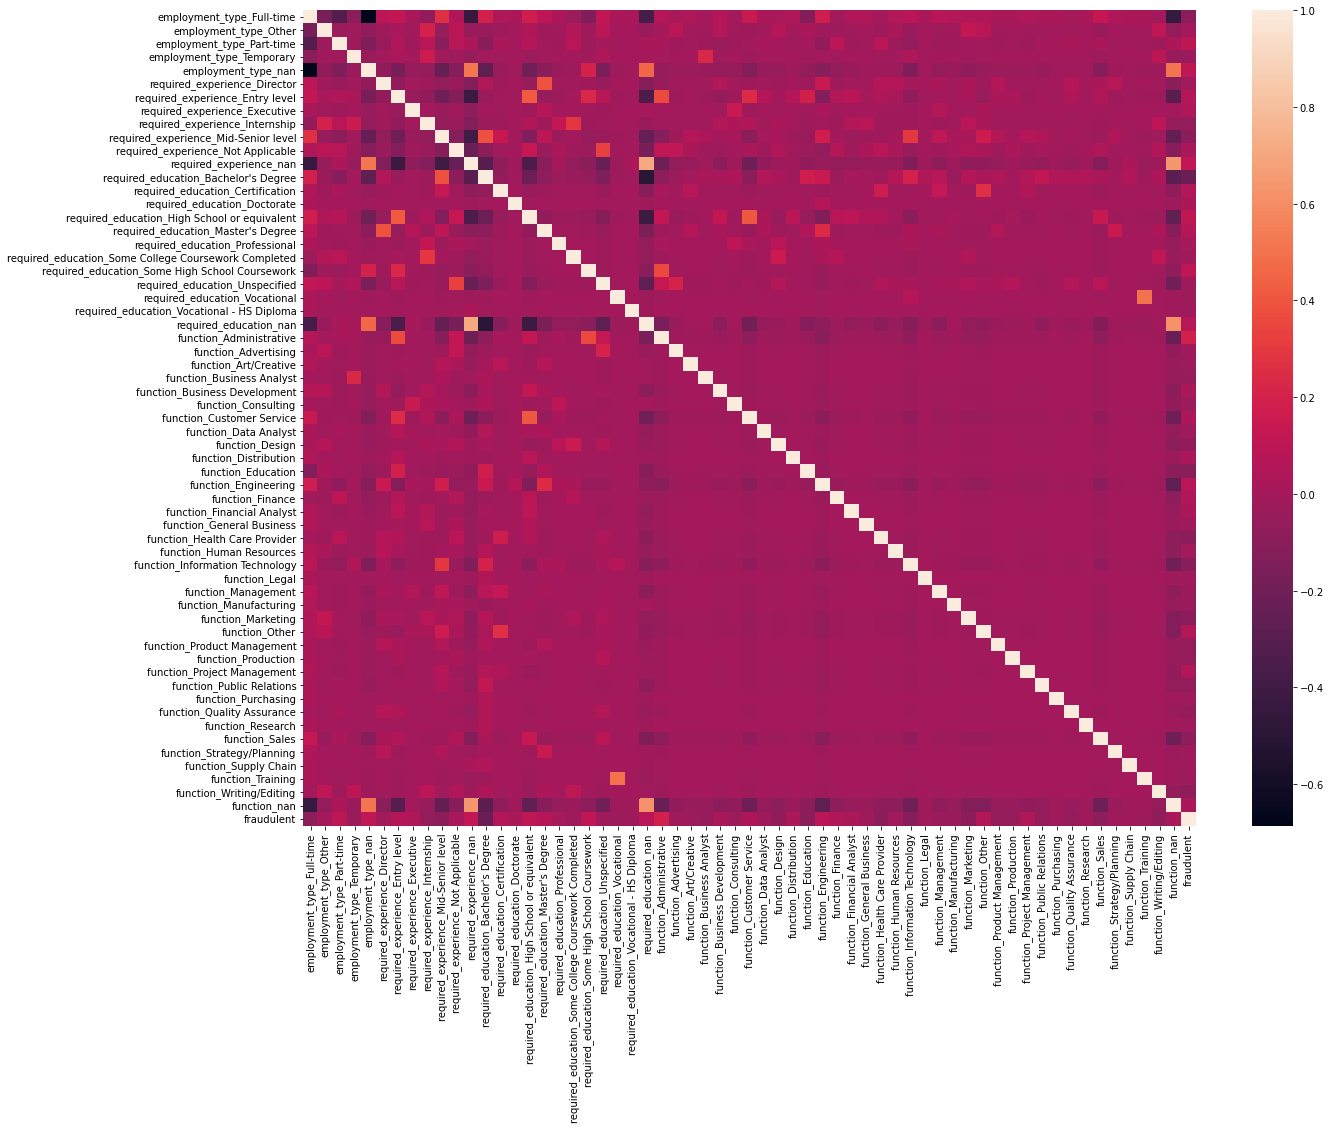

In [71]:
# let's see some correlations between categorical data and the fraudulency

cat_tar = pd.concat([cat_df, Job_under['fraudulent']], axis =1)

plt.figure(figsize = (20,15))
sns.heatmap(cat_tar.corr());

After running perceptrons on both categorical and text data, let's try to run it on "all" the text data (corpus) and then a combination of seemingly relevant text features and categorical features. First, corpus

In [47]:
# Corpus creation
# Not keeping non-text variables in Job_corpus, we can add them back later
Job_corpus_under = pd.DataFrame()
Job_corpus_under['fraudulent'] = Job_under['fraudulent']
Job_corpus_under['corpus'] = text['title'] + ' ' + text['location'] + ' ' + text['department'] + ' ' + text['company_profile'] + ' ' + text['description'] + ' ' + text['requirements'] + ' ' + text['benefits']

# making all text lower case 
Job_corpus_under['corpus'] = Job_corpus_under['corpus'].str.lower()


In [48]:
# vectorizing Job_corpus_under
vectorizer = TfidfVectorizer()
spmat_location = vectorizer.fit_transform(Job_corpus_under['corpus'])
feat_names = vectorizer.get_feature_names_out()
job_corpus_under = pd.DataFrame.sparse.from_spmatrix(spmat_location, columns=feat_names)


In [66]:
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.80, random_state=42)

perc_all_corpus = []
for i in range(1,15):
  model = Perceptron(max_iter = i).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_f1 = f1_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_f1 = f1_score(y_test, y_pred_test)
  perc_all_corpus.append({"Iterations": i, "Training Accuracy": train_acc, "Training F1": train_f1, "Testing Accuracy": test_acc, "Testing F1": test_f1})

perc_all_corpus = pd.DataFrame(perc_all_corpus)
perc_all_corpus

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

,Iterations,Training Accuracy,Training F1,Testing Accuracy,Testing F1
0,1,0.930636,0.932203,0.816739,0.792144
1,2,0.947977,0.949153,0.834776,0.812756
2,3,0.985549,0.986376,0.857143,0.844340
3,4,0.997110,0.997305,0.865801,0.862018
4,5,0.997110,0.997319,0.844877,0.852437
5,6,1.000000,1.000000,0.870130,0.866469
6,7,1.000000,1.000000,0.870130,0.866469
7,8,1.000000,1.000000,0.870130,0.866469
8,9,1.000000,1.000000,0.870130,0.866469
9,10,1.000000,1.000000,0.870130,0.866469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


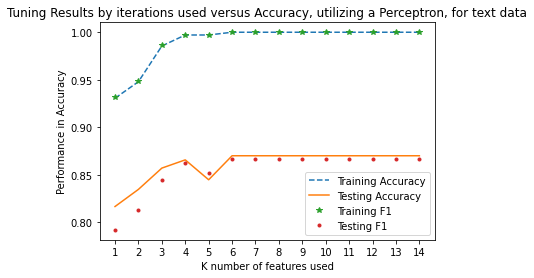

In [88]:
# here is for both training and testing

plt.plot(perc_all_corpus['Iterations'], perc_all_corpus['Training Accuracy'], '--', label='Training Accuracy')
plt.plot(perc_all_corpus['Iterations'], perc_all_corpus['Testing Accuracy'], label='Testing Accuracy')
plt.plot(perc_all_corpus['Iterations'], perc_all_corpus['Training F1'], '*', label='Training F1')
plt.plot(perc_all_corpus['Iterations'], perc_all_corpus['Testing F1'], '.', label='Testing F1')

plt.xticks(perc_all_corpus['Iterations'])
plt.legend(loc = 'bottom right')
plt.xlabel('K number of features used')
plt.ylabel('Performance in Accuracy')
plt.title("Tuning Results by iterations used versus Accuracy, utilizing a Perceptron, for text data");


In [77]:
# combining categorical features and text features

# first, choosing text features based on training error
Job_corpus_cat = pd.DataFrame()
Job_corpus_cat['fraudulent'] = Job_under['fraudulent']
Job_corpus_cat['corpus'] = text['title'] + ' ' + text['location'] + ' ' + text['description']

# making all text lower case 
Job_corpus_cat['corpus'] = Job_corpus_cat['corpus'].str.lower()

# vectorizing Job_corpus_under
vectorizer = TfidfVectorizer()
spmat_location = vectorizer.fit_transform(Job_corpus_cat['corpus'])
feat_names = vectorizer.get_feature_names_out()
job_corpus_less = pd.DataFrame.sparse.from_spmatrix(spmat_location, columns=feat_names)

# combining job_corpus_less with cat_df
job_corpus_cat = pd.concat([job_corpus_less, cat_df], axis = 1)


In [79]:
# now running this on the combined text and categorical data

y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = job_corpus_cat.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.80, random_state=42)

perc_cat_corpus = []
for i in range(1,15):
  model = Perceptron(max_iter = i).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_f1 = f1_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_f1 = f1_score(y_test, y_pred_test)
  perc_cat_corpus.append({"Iterations": i, "Training Accuracy": train_acc, "Training F1": train_f1, "Testing Accuracy": test_acc, "Testing F1": test_f1})

perc_cat_corpus = pd.DataFrame(perc_cat_corpus)
perc_cat_corpus

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame

,Iterations,Training Accuracy,Training F1,Testing Accuracy,Testing F1
0,1,0.595376,0.500000,0.590188,0.514530
1,2,0.632948,0.744467,0.558442,0.684861
2,3,0.927746,0.935733,0.720779,0.747554
3,4,0.777457,0.781870,0.637807,0.646976
4,5,0.933526,0.934097,0.729437,0.688279
5,6,0.959538,0.963542,0.733045,0.762516
6,7,0.988439,0.989130,0.776335,0.773723
7,8,0.904624,0.918519,0.676768,0.741638
8,9,0.924855,0.933673,0.675325,0.727273
9,10,0.997110,0.997305,0.772727,0.775801


# Boosting Methods

In [82]:
# first, to run AdaBoost on the all corpus text data
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.80, random_state=42)

n_estimators = [10,25,50,100,150,200]

ada_all_corpus = []
for i in n_estimators:
  model = AdaBoostClassifier(n_estimators = i).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_f1 = f1_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_f1 = f1_score(y_test, y_pred_test)
  ada_all_corpus.append({"Number of estimators": i, "Training Accuracy": train_acc, "Training F1": train_f1, "Testing Accuracy": test_acc, "Testing F1": test_f1})

pd.DataFrame(ada_all_corpus)



,Number of estimators,Training Accuracy,Training F1,Testing Accuracy,Testing F1
0,10,0.864162,0.869806,0.734488,0.729013
1,25,0.956647,0.960212,0.782107,0.785206
2,50,1.000000,1.000000,0.794372,0.799154
3,100,1.000000,1.000000,0.800144,0.801149
4,150,1.000000,1.000000,0.809524,0.810345
5,200,1.000000,1.000000,0.808802,0.809215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


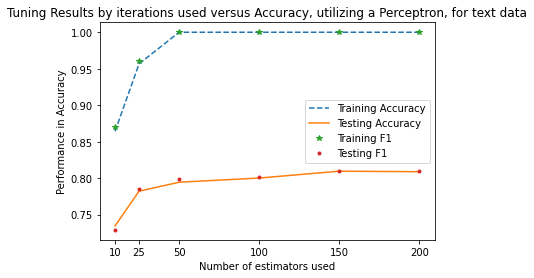

In [89]:
# here is for both training and testing

ada_all_corpus = pd.DataFrame(ada_all_corpus)
plt.plot(ada_all_corpus['Number of estimators'], ada_all_corpus['Training Accuracy'], '--', label='Training Accuracy')
plt.plot(ada_all_corpus['Number of estimators'], ada_all_corpus['Testing Accuracy'], label='Testing Accuracy')
plt.plot(ada_all_corpus['Number of estimators'], ada_all_corpus['Training F1'], '*', label='Training F1')
plt.plot(ada_all_corpus['Number of estimators'], ada_all_corpus['Testing F1'], '.', label='Testing F1')

plt.xticks(ada_all_corpus['Number of estimators'])
plt.legend(loc = 'bottom right')
plt.xlabel('Number of estimators used')
plt.ylabel('Performance in Accuracy')
plt.title("Tuning Results by iterations used versus Accuracy, utilizing a Perceptron, for text data");

In [83]:
# first, to run AdaBoost on the categorical and text data
y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = job_corpus_cat.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.80, random_state=42)

n_estimators = [10,25,50,100,150,200]

ada_cat_corpus = []
for i in n_estimators:
  model = AdaBoostClassifier(n_estimators = i).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  train_f1 = f1_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  test_f1 = f1_score(y_test, y_pred_test)
  ada_cat_corpus.append({"Number of estimators": i, "Training Accuracy": train_acc, "Training F1": train_f1, "Testing Accuracy": test_acc, "Testing F1": test_f1})

pd.DataFrame(ada_cat_corpus)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse co

,Number of estimators,Training Accuracy,Training F1,Testing Accuracy,Testing F1
0,10,0.838150,0.851852,0.698413,0.703546
1,25,0.927746,0.932249,0.735931,0.735166
2,50,0.997110,0.997305,0.733766,0.733189
3,100,1.000000,1.000000,0.750361,0.748547
4,150,1.000000,1.000000,0.754690,0.752907
5,200,1.000000,1.000000,0.766234,0.762463


# KNN

In [90]:
#This function is supposed to create and test a KNN model

def k_neighbors(xtrain, ytrain, xtest, ytest, kvalues, metric):
  knn_accuracy = []
  clfs = []
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric, n_neighbors=i).fit(xtrain, ytrain)
    clf_train_pred = clf.predict(xtrain)
    clf_test_pred = clf.predict(xtest)
    clfs.append(clf)
    knn_accuracy.append({'k values': i,
    'Training Accuracy':accuracy_score(clf_train_pred,ytrain),
    'Training F1': f1_score(clf_train_pred, y_train),
    'Test Accuracy': accuracy_score(clf_test_pred,ytest),
    'Test F1': f1_score(clf_test_pred,ytest)})
  return pd.DataFrame(knn_accuracy), clfs

In [92]:
# running all corpus data through KNN Function / model

y = y_under
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = job_corpus_under.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.80, random_state=42)

knn_all_scores, knn_all_clfs = k_neighbors(X_train, y_train, X_test, y_test, range(1, 30, 2), 'euclidean')

knn_all_scores

,k values,Training Accuracy,Training F1,Test Accuracy,Test F1
0,1,1.000000,1.000000,0.808802,0.816100
1,3,0.919075,0.926702,0.792208,0.800277
2,5,0.878613,0.891753,0.791486,0.801101
3,7,0.838150,0.856410,0.784271,0.796737
4,9,0.852601,0.869565,0.788600,0.801356
5,11,0.878613,0.893401,0.794372,0.807041
6,13,0.846821,0.866499,0.795094,0.808883
7,15,0.858382,0.874680,0.797258,0.811283
8,17,0.849711,0.867347,0.792929,0.806473
9,19,0.846821,0.863753,0.792208,0.804348


Text(0.5, 1.0, 'Tuning Results by K number of neighbors versus Accuracy, \n measured by Euclidean distance metric')

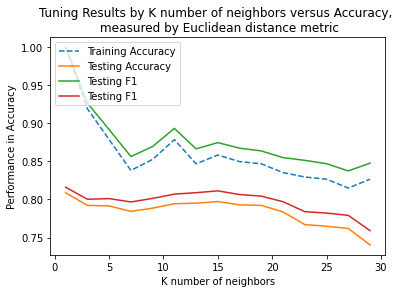

In [94]:
# Plotting of accuracies training and testing of K-nn with Euclidean metric

plt.plot(range(1,30,2),knn_all_scores['Training Accuracy'],'--', label='Training Accuracy')
plt.plot(range(1,30,2),knn_all_scores['Test Accuracy'], label='Testing Accuracy')
plt.plot(range(1,30,2),knn_all_scores['Training F1'], label='Testing F1')
plt.plot(range(1,30,2),knn_all_scores['Test F1'], label='Testing F1')


plt.legend(loc='upper left')
plt.xlabel('K number of neighbors')
plt.ylabel('Performance in Accuracy')
plt.title("Tuning Results by K number of neighbors versus Accuracy, \n measured by Euclidean distance metric")

# Pre-processing of salary range

In [ ]:
job['salary_range'].unique()

array([nan, '20000-28000', '100000-120000', '120000-150000',
       '50000-65000', '40000-50000', '60-80', '65000-70000', '75-115',
       '75000-110000', '17000-20000', '16000-28000', '95000-115000',
       '15000-18000', '50000-70000', '45000-60000', '30000-40000',
       '70000-90000', '10000-14000', '50-110', '28000-45000', '0-34300',
       '35000-40000', '9-Dec', '44000-57000', '18500-28000',
       '55000-75000', '30000-35000', '0-0', '20000-40000',
       '360000-600000', '50000-80000', '80000-100000', '52000-78000',
       '15750-15750', '40000-65000', '45000-50000', '30000-37000',
       '45000-67000', '35000-100000', '180000-216000', '45000-65000',
       '28000-32000', '0-1000', '36000-40000', '80000-110000',
       '35000-73000', '19000-19000', '60000-120000', '120000-15000000',
       '42000-55000', '90000-120000', '100000-150000', '28000-38000',
       '1600-1700', '50000-60000', '30000-70000', '32000-40000', '50-100',
       '9000-17000', '23040-28800', '105-110', '1300

Quite a mess within salary range. There are dates, numbers on different scales, and they're all strings

In [ ]:
salary_range_new = []
months = [['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov', 'Dec']]
for i in job['salary_range']:
  if '-' in i:
    low = i.split('-')[0]
    high = i.split('-')[1]
    salary_range_new.append({'min': low, 'max': high})
    

TypeError: ignored

In [ ]:
salary_range_new

### Trying (and failing) to clean salary range in one fell swoop

In [ ]:
salary_range_new = []
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov', 'Dec']
for i in job['salary_range']:
  if '-' in i:
    low = i.split('-')[0]
    high = i.split('-')[1]
    if low or high not in months: 
      if int(low) < 100 and int(high) < 100:
        low = int(low) * 1000
        high = int(high) * 1000
        salary_range_new.append({'min': low, 'max': high})
      else:
          salary_range_new.append({'min': int(low), 'max': int(high)})
    else:
      salary_range_new.append({"old": i})
  else: 
    salary_range_new.append({"old": i})
